# Automatic Plotting of Stock Support and Resistance Levels
## Support and Resistance levels are stock prices that the stock has visited multiple times and that could reverse the stock trajectory

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.graph_objects as go
import yfinance as yf
from scipy.signal import argrelextrema

In [24]:
stock = yf.Ticker("AMD")
hist = stock.history(period='2y', interval='1d')

In [25]:
print(hist.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-10-28 to 2021-10-27
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          505 non-null    float64
 1   High          505 non-null    float64
 2   Low           505 non-null    float64
 3   Close         505 non-null    float64
 4   Volume        505 non-null    int64  
 5   Dividends     505 non-null    int64  
 6   Stock Splits  505 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 31.6 KB
None


In [26]:
def plot_price_history(price_df):
    fig = go.Figure(data=[go.Candlestick(x=price_df.index,
                    open=price_df['Open'],
                    high=price_df['High'],
                    low=price_df['Low'],
                    close=price_df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

In [27]:
plot_price_history(hist)

### Relative Maxima and Minima are used as significant points that can create support/resistance levels

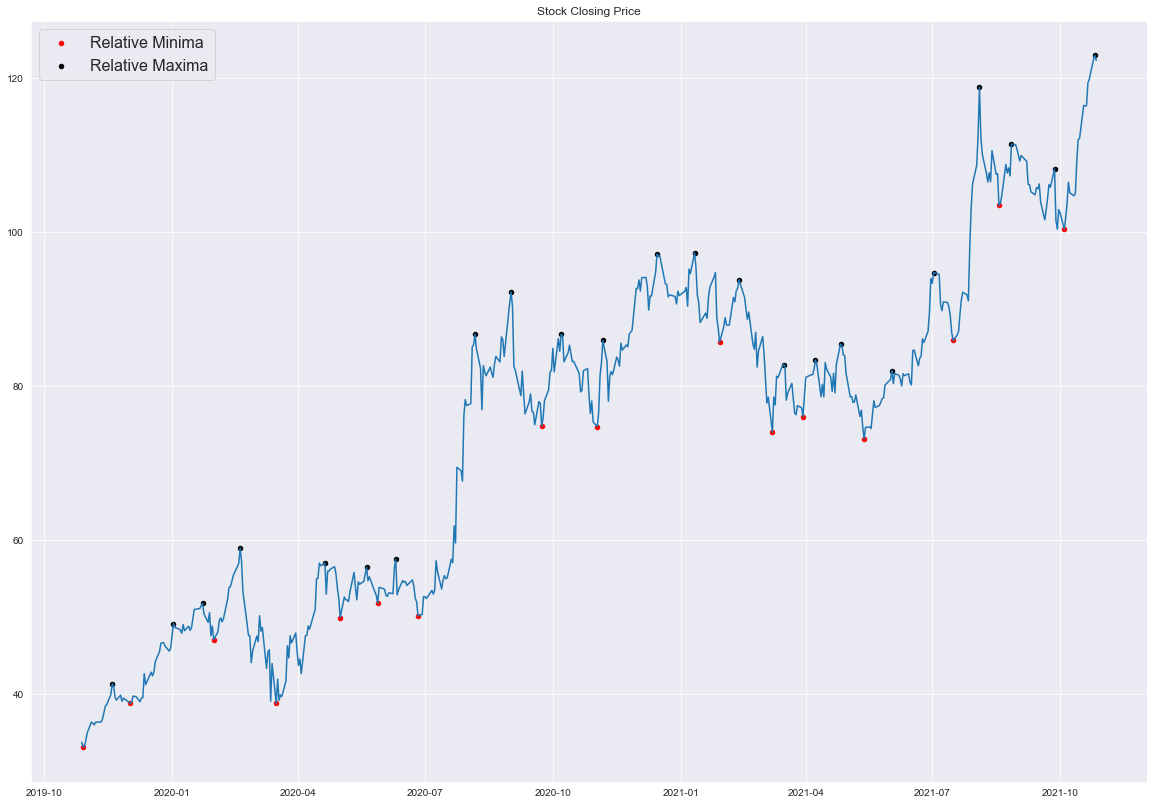

In [28]:
n = 9
hist['Min'] = hist.Close.iloc[argrelextrema(hist.Close.values, np.less_equal, order=n)[0]]
hist['Max'] = hist.Close.iloc[argrelextrema(hist.Close.values, np.greater_equal, order=n)[0]]

plt.figure(figsize=(20,14))
plt.plot(hist.index, hist.Close)
plt.scatter(hist.index, hist.Min, c='red', s=20, label='Relative Minima')
plt.scatter(hist.index, hist.Max, c='black', s=20, label='Relative Maxima')
plt.title('Stock Closing Price')
plt.legend(loc='upper left', fontsize=16)
plt.show()

### Create support and resistance levels with automatic tolerance and required point count.
### This could be improved as different stock timescales require different criteria when choosing support/resistance levels.
### Another issue is that stock prices are non-stationary and can change distribution over time, meaning that different tolerance values are needed during a stock's history.

In [29]:
hist['Min_or_Max'] = hist.Max.combine_first(hist.Min)
hist_range = hist.Close.max() - hist.Close.min()
tol = hist_range / hist.Close.std()
req_points = int(tol) - 1
print(f'Required number of points to make level: {req_points}')
print(f'Max distance between points in same level: {str(tol)}\n')
print(hist.Close.describe())
levels = []

min_max_vals = hist.Min_or_Max.sort_values(ascending=False).tolist()
current_level = min_max_vals[0]

cluster = []
# Points that are near the top or bottom of the data are more important
weighted_cluster_size = 0
for i in range(1, len(min_max_vals)):
    if abs(min_max_vals[i] - current_level) <= tol:
        cluster.append(min_max_vals[i])

        weighted_cluster_size += 1
        # Extra weighting for extreme points
        if i <= 4 or i >= len(min_max_vals) - 5:
            weighted_cluster_size += 1

    else:
        if weighted_cluster_size >= req_points:
            levels.append(np.array(cluster).mean())

        current_level = min_max_vals[i]        
        cluster = []
        weighted_cluster_size = 0


Required number of points to make level: 3
Max distance between points in same level: 4.091399587939166

count    505.000000
mean      74.040040
std       21.972921
min       33.029999
25%       52.919998
50%       79.419998
75%       89.449997
max      122.930000
Name: Close, dtype: float64


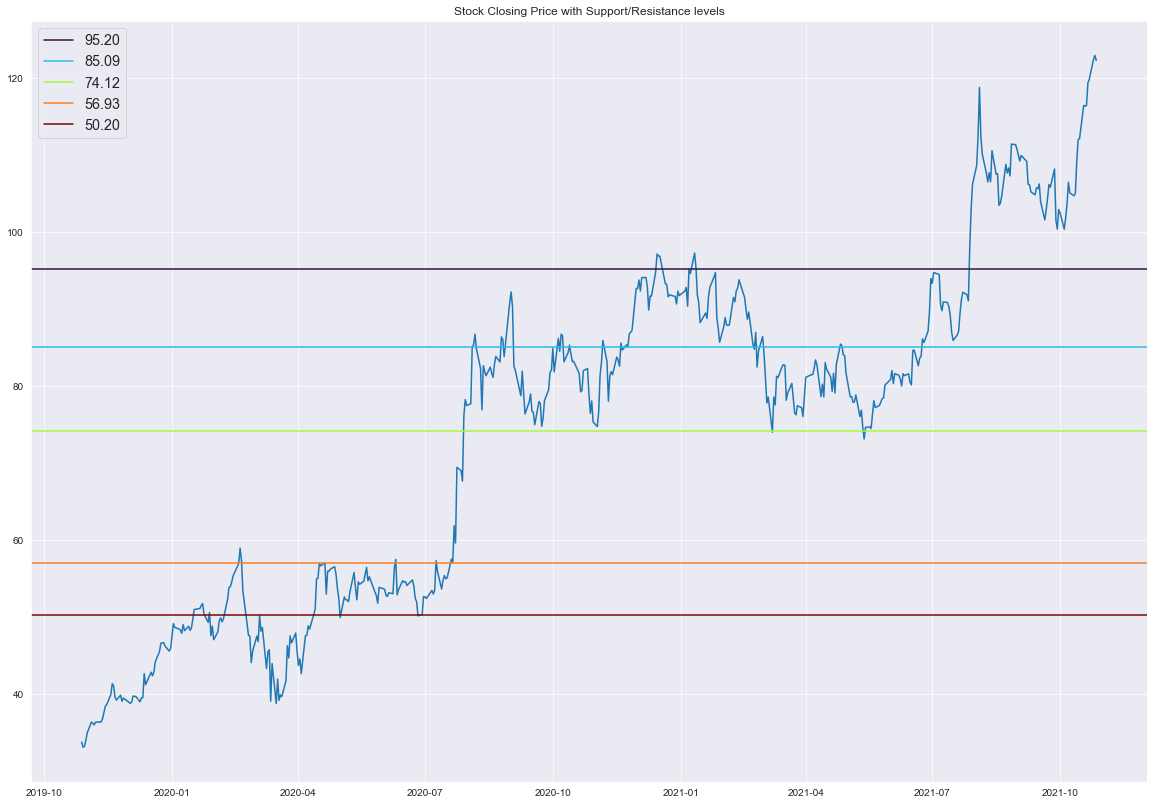

In [30]:
if len(levels) > 0:
    plt.figure(figsize=(20,14))
    plt.plot(hist.index, hist.Close)

    color=iter(plt.cm.turbo(np.linspace(0,1,len(levels))))
    for level in levels:
        c=next(color)
        plt.axhline(level, color=c, label="{:5.2f}".format(level))

    plt.legend(loc='upper left', fontsize='x-large')
    plt.title('Stock Closing Price with Support/Resistance levels')
    plt.show()
else:
    print('No support or resistance levels found!')